# Lecture 7: Dimension Reduction and Clustering

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_20newsgroups, load_digits
from sklearn.feature_extraction.text import TfidfVectorizer

# these are new imports for dimensionality reduction
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE
# these are new imports for clustering
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage, dendrogram

## Dimension Reduction

### PCA

The R package [`cluster.datasets`](http://cran.r-project.org/web/packages/cluster.datasets/cluster.datasets.pdf) has some good datasets for experimenting with unsupervised learning techniques like dimensionality reduction and clustering.  Here, we'll use the `cake.ingredients.1961` dataset of cake recipes, which I've exported to a CSV.

In [3]:
cakes = pd.read_csv("./cakes.csv")
# strip trailing whitespace in the names
cakes["Cake"] = cakes.Cake.str.strip()
cakes.head()

,Cake,AE,BM,BP,BR,BS,CA,CC,CE,CI,...,SA,SC,SG,SR,SS,ST,VE,WR,YT,ZH
0,Angel,0.25,0,0,0.00,0,0,0.0,0,0,...,0,0,0,1.50,0,0.25,1,0.00,0.0,0
1,Babas au Rhum,0.00,0,0,0.25,0,0,0.0,0,0,...,0,0,0,0.25,0,0.00,0,0.25,0.6,0
2,Sweet Chocolate,0.00,0,0,1.00,0,0,0.0,4,0,...,1,0,0,2.00,0,0.50,1,0.50,0.0,0
3,Buche de Noel,0.00,0,0,0.00,0,0,0.0,0,0,...,0,0,0,1.30,0,0.50,1,0.00,0.0,0
4,Cheesecake,0.00,0,0,0.25,0,0,1.5,0,0,...,0,1,0,1.00,0,0.25,0,0.00,0.0,6


Let's store a dictionary of the ingredient abbreviations so we can look them up:

In [4]:
ingredients_dict = {
    "AE": "Almond essence",
    "BM": "Buttermilk",
    "BP": "Baking powder",
    "BR": "Butter",
    "BS": "Bananas",
    "CA": "Cocoa",
    "CC": "Cottage Cheese",
    "CE": "Chocolate",
    "CI": "Crushed Ice",
    "CS": "Crumbs",
    "CT": "Cream of tartar",
    "DC": "Dried currants",
    "EG": "Eggs",
    "EY": "Egg white",
    "EW": "Egg yolk",
    "FR": "Sifted flour",
    "GN": "Gelatin",
    "HC": "Heavy cream",
    "LJ": "Lemon juice",
    "LR": "Lemon",
    "MK": "Milk",
    "NG": "Nutmeg",
    "NS": "Nuts",
    "RM": "Rum",
    "SA": "Soda",
    "SC": "Sour cream",
    "SG": "Shortening",
    "SR": "Granulated sugar",
    "SS": "Strawberries",
    "ST": "Salt",
    "VE": "Vanilla extract",
    "WR": "Water",
    "YT": "Yeast",
    "ZH": "Zwiebach"
}

Get rid of the column of cake names so that we have a numeric only dataframe:

In [5]:
X = cakes.iloc[:, 1:]
X.head()

,AE,BM,BP,BR,BS,CA,CC,CE,CI,CS,...,SA,SC,SG,SR,SS,ST,VE,WR,YT,ZH
0,0.25,0,0,0.00,0,0,0.0,0,0,0,...,0,0,0,1.50,0,0.25,1,0.00,0.0,0
1,0.00,0,0,0.25,0,0,0.0,0,0,0,...,0,0,0,0.25,0,0.00,0,0.25,0.6,0
2,0.00,0,0,1.00,0,0,0.0,4,0,0,...,1,0,0,2.00,0,0.50,1,0.50,0.0,0
3,0.00,0,0,0.00,0,0,0.0,0,0,0,...,0,0,0,1.30,0,0.50,1,0.00,0.0,0
4,0.00,0,0,0.25,0,0,1.5,0,0,0,...,0,1,0,1.00,0,0.25,0,0.00,0.0,6


In [6]:
X.shape

(18, 34)

First, we'll run a simple PCA using the [scikit-learn class](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html).  If we don't specify `n_components` or set it to `None`, it will use the maximum number of principal components:

In [ ]:
pca = PCA(n_components=None)
pca.fit(X)

Let's take a look at the explained variance of each of the principal components:

In [ ]:
pca.explained_variance_ratio_

And plot it:

In [ ]:
plt.plot(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_)
plt.scatter(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_)
plt.xlabel("Principal Components Number")
plt.ylabel("Percentage of Variance Explained")
plt.show()

In [ ]:
cumsum = np.cumsum(pca.explained_variance_ratio_)
plt.plot(range(len(pca.explained_variance_ratio_)), cumsum)
plt.scatter(range(len(pca.explained_variance_ratio_)), cumsum)
plt.xlabel("Principal Components Number")
plt.ylabel("Cumulative Percentage of Variance Explained")
plt.show()

If we're looking for an "elbow", it looks like roughly 6 or 7 principal components would be enough.  To actually get each row transformed into the principal component space, we can call `transform` on an already fit `PCA` object, or we can do both at once with `fit_transform`:

In [ ]:
pca = PCA(n_components=2)
X_trans = pca.fit_transform(X)
X_trans

Next, let's define a function for plotting:

In [ ]:
def plot_PCA(pca, X, print_row_labels, row_labels, col_labels, biplot=False, y_scale=(None, None), font_size=None):
    # transform our data to PCA space
    X_trans = pca.fit_transform(X)

    # handle the scaling of the plot
    xmin, xmax = min(X_trans[:, 0]), max(X_trans[:, 0])
    if y_scale == (None, None):
        ymin, ymax = min(X_trans[:, 1]), max(X_trans[:, 1])
        xpad, ypad = 5, 5
    else:
        ymin, ymax = y_scale
        xpad, ypad = 5, 1
        
    plt.xlim(xmin - xpad, xmax + xpad)
    plt.ylim(ymin - ypad, ymax + ypad)

    # plot words instead of points
    if print_row_labels:
        for x, y, label in zip(X_trans[:, 0], X_trans[:, 1], row_labels):
            if font_size is None:
                plt.text(x, y, label)
            else:
                plt.text(x, y, label, size=font_size)
    else:
        for x, y in zip(X_trans[:, 0], X_trans[:, 1]):
            plt.scatter(x, y)
    plt.xlabel("PC 1")
    plt.ylabel("PC 2")

    # if we want a biplot, get the loading and plot
    # axes with labels
    if biplot:
        eigenvectors = pca.components_.transpose()
        for i, col in enumerate(col_labels):
            x, y = 10*eigenvectors[i][0], 10*eigenvectors[i][1]
            plt.arrow(0, 0, x, y, color='r', width=0.002, head_width=0.05)
            plt.text(x* 1.4, y * 1.4, col, color='r', ha='center', va='center')
    
    plt.show()

In [ ]:
pca = PCA(n_components=2)
plot_PCA(pca, X, True, cakes.Cake, X.columns, biplot=True)

Here, we ran PCA on a totally unscaled version of the dataset, so we see that we're influenced by two large outliers.  The first principal component is dominated by "cocoa" and "shortening" because the "One Bowl Chocolate" cake has a huge amount of these.  The second principal component is dominated by "egg whites" because of the "Angel" foodcake recipe.

In [ ]:
cake = "One Bowl Chocolate"
#cake = "Angel"
cakes[cakes.Cake==cake].transpose()

In [ ]:
#cakes.CA
#cakes.SG
cakes.EW
#cakes.EG

Let's try mean-centering the columns first:

In [ ]:
pca = PCA(n_components=2)
X_scaled = scale(X, with_mean=True, with_std=False)
plot_PCA(pca, X_scaled, True, cakes.Cake, X.columns, biplot=True)

And now both center and scale to unit variance:

In [ ]:
pca = PCA(n_components=2)
X_scaled = scale(X, with_mean=True, with_std=True)
plot_PCA(pca, X_scaled, True, cakes.Cake, X.columns, biplot=True)

Let's look at a zoomed in version:

In [ ]:
X_scaled

In [ ]:
pca = PCA(n_components=2)
X_scaled = scale(X, with_mean=True, with_std=True)
plot_PCA(pca, X_scaled, True, cakes.Cake, X.columns, biplot=True, y_scale=(-1, 1))

To me, it looks like cheesecakes are off to the right on the first principal component, and the second principal component is quantifying whether the cake has fruit or not...

### t-SNE

Let's switch for a moment to the handwritten digits dataset that we saw before in the notebook on k-nearest neighbors:

In [34]:
digits = load_digits()
digits_data = scale(digits.data)

labels = digits.target

In [35]:
digits_data.shape

(1797, 64)

In [36]:
pca = PCA(n_components=2)
digits_trans = pca.fit_transform(digits_data)

Let's make a plot of the first two principal components, colored and labeled by the true digit:

In [ ]:
xmin, xmax = min(digits_trans[:, 0]), max(digits_trans[:, 0])
ymin, ymax = min(digits_trans[:, 1]), max(digits_trans[:, 1])
xpad, ypad = 5, 5
plt.xlim(xmin - xpad, xmax + xpad)
plt.ylim(ymin - ypad, ymax + ypad)

for x, y, label in zip(digits_trans[:, 0], digits_trans[:, 1], labels):
    plt.text(x, y, label, size=8, color=plt.cm.Set1(label/10.))

plt.xlabel("PC 1")
plt.ylabel("PC 2")

plt.show()

If our goal is visualizing the high dimensional dataset, the [t-SNE](http://lvdmaaten.github.io/tsne/) algorithm usually does a superior job of finding structure in the high-dimensional data that can be visualized in two dimensions.  There's a [scikit-learn class](http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html#sklearn.manifold.TSNE) for running t-SNE.

In [37]:
tsne = TSNE(n_components=2, verbose=True)
digits_trans = tsne.fit_transform(digits_data)

[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 1000 / 1797
[t-SNE] Computed conditional probabilities for sample 1797 / 1797
[t-SNE] Mean sigma: 2.294230
[t-SNE] Error after 83 iterations with early exaggeration: 15.691575
[t-SNE] Error after 179 iterations: 1.068995


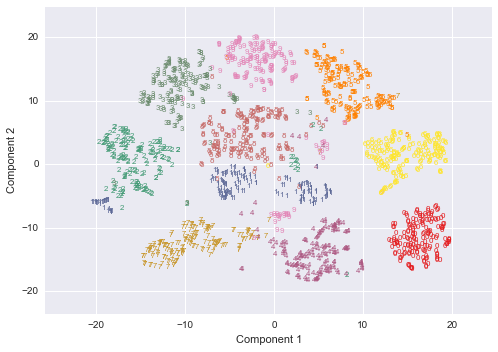

In [38]:
xmin, xmax = min(digits_trans[:, 0]), max(digits_trans[:, 0])
ymin, ymax = min(digits_trans[:, 1]), max(digits_trans[:, 1])
xpad, ypad = 5, 5
plt.xlim(xmin - xpad, xmax + xpad)
plt.ylim(ymin - ypad, ymax + ypad)

#for x, y, label in zip(digits_trans[labels==6, 0], digits_trans[labels==6, 1], labels[labels==6]):
for x, y, label in zip(digits_trans[:, 0], digits_trans[:, 1], labels):
    plt.text(x, y, label, size=8, color=plt.cm.Set1(label/10.))

plt.xlabel("Component 1")
plt.ylabel("Component 2")

plt.show()

This clearly does a better job at finding the "structure" in the high-dimensional dataset.  Notice that 3, 5, and 9 end up near each other.  But there are some 1's that are closer to the 2's, and some 9's that are closer to the 7's and the 1's.

## Clustering

### Hierarchical

Now back to cakes.  We'll use some functions from scipy to run hierarchical clustering.  `linkage` calculates the distances and linkages, and `dendrogram` displays the actual tree dendrogram:

In [7]:
clusters_single = linkage(scale(X), method='single', metric="euclidean") # single, complete, average, and ward methods

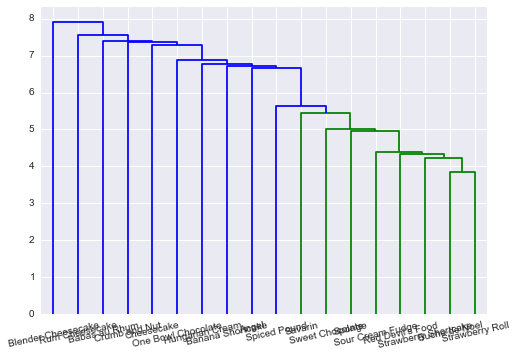

In [8]:
dendr = dendrogram(clusters_single, orientation="top", labels=list(cakes.Cake))

As ISLR says, single linkage tends to produce really unbalanced trees.  We can put the dendrogram on its side to make it easier to visualize:

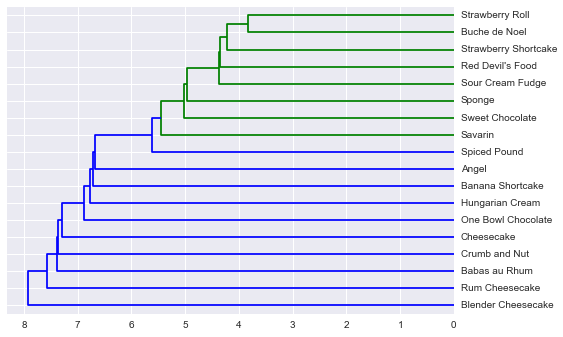

In [9]:
dendr = dendrogram(clusters_single, orientation="right", labels=list(cakes.Cake))

In [10]:
clusters_complete = linkage(scale(X), method='complete', metric="euclidean") # single, complete, average, and ward methods

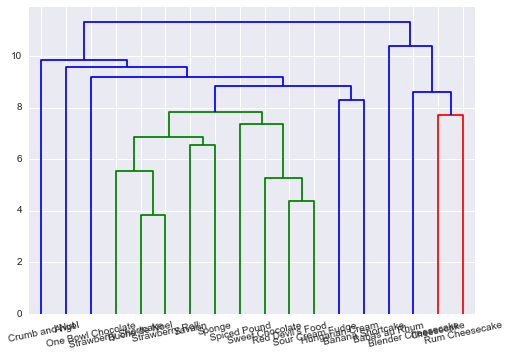

In [11]:
dendr = dendrogram(clusters_complete, orientation="top", labels=list(cakes.Cake))

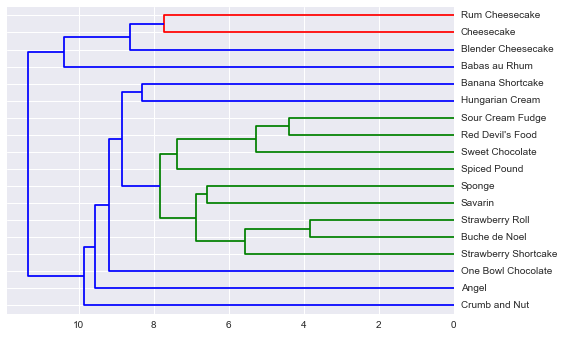

In [12]:
dendr = dendrogram(clusters_complete, orientation="right", labels=list(cakes.Cake))

In [13]:
clusters_ward = linkage(scale(X), method='ward', metric="euclidean") # single, complete, average, and ward methods

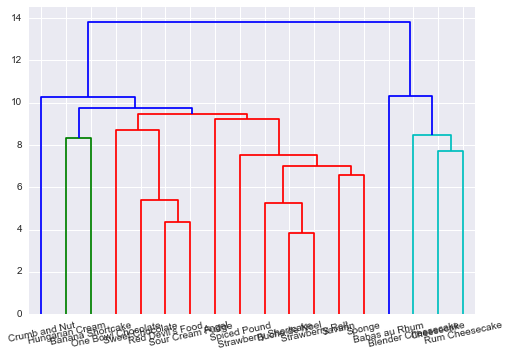

In [14]:
dendr = dendrogram(clusters_ward, orientation="top", labels=list(cakes.Cake))

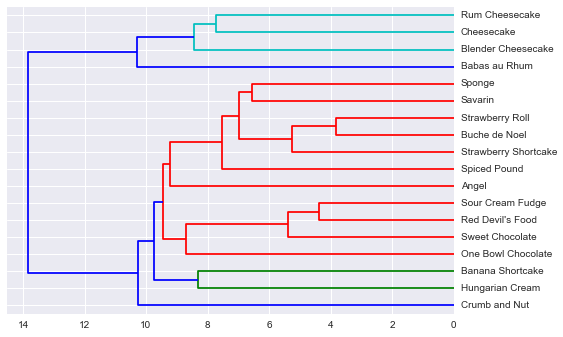

In [15]:
dendr = dendrogram(clusters_ward, orientation="right", labels=list(cakes.Cake))

The clustering is doing something sensible: the cheesecakes group together and are on their own, the chocolate cakes are together (sour cream fudge, red devil's, sweet chocolate, and one bowl chocolate), etc.

### k-Means

As a general resource, the [scikit-learn clustering page](http://scikit-learn.org/stable/modules/clustering.html) is great.  It has all the different kinds of clustering algorithms with their pros and cons.  Here, we'll focus on k-means.

In [16]:
# init can be k-means++ or random; k-means++ is just a smarter version of random that forces the
# centers to be further apart
kmeans = KMeans(n_clusters=10, init='k-means++', n_init=10, max_iter=300, verbose=True, n_jobs=1)

In [20]:
kmeans.fit(digits_data)

Initialization complete
Iteration  0, inertia 108944.680
Iteration  1, inertia 77112.728
Iteration  2, inertia 74523.382
Iteration  3, inertia 73300.991
Iteration  4, inertia 72675.559
Iteration  5, inertia 72394.092
Iteration  6, inertia 72137.870
Iteration  7, inertia 71890.486
Iteration  8, inertia 71834.932
Iteration  9, inertia 71770.470
Iteration 10, inertia 71710.952
Iteration 11, inertia 71667.708
Iteration 12, inertia 71660.076
Iteration 13, inertia 71656.890
Iteration 14, inertia 71652.222
Iteration 15, inertia 71644.496
Iteration 16, inertia 71638.102
Iteration 17, inertia 71631.275
Iteration 18, inertia 71623.949
Iteration 19, inertia 71622.798
Iteration 20, inertia 71617.632
Iteration 21, inertia 71614.747
Iteration 22, inertia 71613.721
Iteration 23, inertia 71613.460
Iteration 24, inertia 71612.725
Iteration 25, inertia 71611.695
Iteration 26, inertia 71609.521
Iteration 27, inertia 71608.041
Iteration 28, inertia 71604.584
Iteration 29, inertia 71601.984
Iteration 30, i

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=10, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=True)

We can see the assigned cluster or label of each data point:

In [21]:
kmeans.labels_

array([6, 5, 5, ..., 5, 2, 2], dtype=int32)

And the cluster centers themselves:

In [22]:
kmeans.cluster_centers_.shape

(10, 64)

The "intertia" tells us the within cluster sum-of-squares, or the "sum of distances of samples to their closest cluster center."

In [23]:
kmeans.inertia_

69426.071618739195

Here, we make a plot where we color by the k-means label instead of the true label.  We can see that things are decent, but definitely more confused than with the true labels:

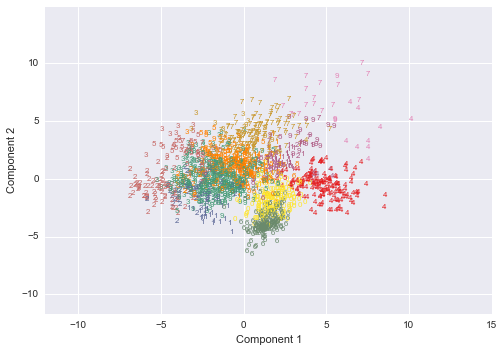

In [26]:
xmin, xmax = min(digits_trans[:, 0]), max(digits_trans[:, 0])
ymin, ymax = min(digits_trans[:, 1]), max(digits_trans[:, 1])
xpad, ypad = 5, 5
plt.xlim(xmin - xpad, xmax + xpad)
plt.ylim(ymin - ypad, ymax + ypad)

for x, y, true_label, kmeans_label in zip(digits_trans[:, 0], digits_trans[:, 1], labels, kmeans.labels_):
    plt.text(x, y, true_label, size=8, color=plt.cm.Set1(kmeans_label/10.))

plt.xlabel("Component 1")
plt.ylabel("Component 2")

plt.show()

We can call the `predict` method, which will tell us which cluster center some new data is closest too:

In [27]:
kmeans.predict(digits_data)

array([6, 5, 5, ..., 5, 2, 2], dtype=int32)

The `transform` method will transform data into the cluster distance space.  That is, how far the point is from each cluster center:

In [ ]:
transformed = kmeans.transform(digits_data)
transformed[0, :]

For very large datasets, there's a much faster implementation of k-means called [mini-batch k-means](http://www.eecs.tufts.edu/~dsculley/papers/fastkmeans.pdf), and a [scikit-learn class](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.MiniBatchKMeans.html) for running it:

In [28]:
mb_kmeans = MiniBatchKMeans(n_clusters=10, batch_size=100, init='k-means++', n_init=10, max_iter=300, verbose=True)

In [29]:
mb_kmeans.fit(digits_data)

Init 1/10 with method: k-means++
Inertia for init 1/10: 12702.223979
Init 2/10 with method: k-means++
Inertia for init 2/10: 12499.096112
Init 3/10 with method: k-means++
Inertia for init 3/10: 12372.622417
Init 4/10 with method: k-means++
Inertia for init 4/10: 10379.503715
Init 5/10 with method: k-means++
Inertia for init 5/10: 12045.230918
Init 6/10 with method: k-means++
Inertia for init 6/10: 11342.956594
Init 7/10 with method: k-means++
Inertia for init 7/10: 12714.563932
Init 8/10 with method: k-means++
Inertia for init 8/10: 12347.763459
Init 9/10 with method: k-means++
Inertia for init 9/10: 12382.462151
Init 10/10 with method: k-means++
Inertia for init 10/10: 11642.155694
Minibatch iteration 1/5400: mean batch inertia: 34.057972, ewa inertia: 34.057972 
Minibatch iteration 2/5400: mean batch inertia: 72.005757, ewa inertia: 38.279083 
Minibatch iteration 3/5400: mean batch inertia: 36.317036, ewa inertia: 38.060835 
Minibatch iteration 4/5400: mean batch inertia: 37.377745, 

MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
        init_size=None, max_iter=300, max_no_improvement=10, n_clusters=10,
        n_init=10, random_state=None, reassignment_ratio=0.01, tol=0.0,
        verbose=True)

In [30]:
mb_kmeans.labels_

array([7, 8, 8, ..., 8, 4, 9], dtype=int32)

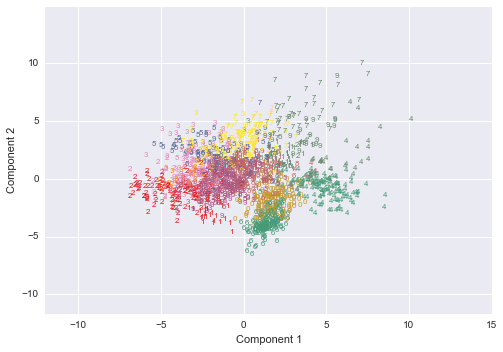

In [31]:
xmin, xmax = min(digits_trans[:, 0]), max(digits_trans[:, 0])
ymin, ymax = min(digits_trans[:, 1]), max(digits_trans[:, 1])
xpad, ypad = 5, 5
plt.xlim(xmin - xpad, xmax + xpad)
plt.ylim(ymin - ypad, ymax + ypad)

for x, y, true_label, kmeans_label in zip(digits_trans[:, 0], digits_trans[:, 1], labels, mb_kmeans.labels_):
    plt.text(x, y, true_label, size=8, color=plt.cm.Set1(kmeans_label/10.))

plt.xlabel("Component 1")
plt.ylabel("Component 2")

plt.show()

Let's see if we can re-cover the "correct" number of clusters using the silhouette statistic:

In [32]:
n_clusters = range(3, 70, 2)
silhouette_stats = []
for this_n_clusters in n_clusters:
    print "Fitting %s clusters..." % this_n_clusters
    kmeans = KMeans(n_clusters=this_n_clusters, init='k-means++', n_init=10, max_iter=300, verbose=False, n_jobs=1)
    kmeans.fit(digits_data)
    labels = kmeans.labels_
    silhouette_stats.append(silhouette_score(digits_data, labels, metric='euclidean'))

Fitting 3 clusters...
Fitting 5 clusters...
Fitting 7 clusters...
Fitting 9 clusters...
Fitting 11 clusters...
Fitting 13 clusters...
Fitting 15 clusters...
Fitting 17 clusters...
Fitting 19 clusters...
Fitting 21 clusters...
Fitting 23 clusters...
Fitting 25 clusters...
Fitting 27 clusters...
Fitting 29 clusters...
Fitting 31 clusters...
Fitting 33 clusters...
Fitting 35 clusters...
Fitting 37 clusters...
Fitting 39 clusters...
Fitting 41 clusters...
Fitting 43 clusters...
Fitting 45 clusters...
Fitting 47 clusters...
Fitting 49 clusters...
Fitting 51 clusters...
Fitting 53 clusters...
Fitting 55 clusters...
Fitting 57 clusters...
Fitting 59 clusters...
Fitting 61 clusters...
Fitting 63 clusters...
Fitting 65 clusters...
Fitting 67 clusters...
Fitting 69 clusters...


/Users/mdagostino/.virtualenvs/jupyter/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


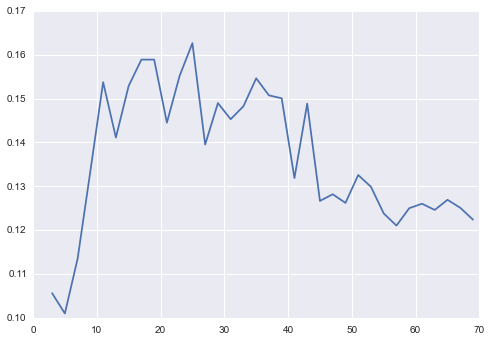

In [33]:
plt.plot(n_clusters, silhouette_stats)
plt.show()

## Text Data

In this example, we'll do dimension reduction and clustering on some text data--the 20 newsgroups dataset from last week:

In [ ]:
data_train = fetch_20newsgroups(subset='train', categories=None,
                                shuffle=True, random_state=42,
                                remove=('headers', 'footers', 'quotes'))

In [ ]:
data_train.target_names

Let's only keep the 'rec.sport.baseball', 'rec.autos', 'sci.space', and 'talk.politics.guns' categories:

In [ ]:
to_keep = np.where([name in [9, 7, 14, 16] for name in data_train.target])[0]
to_keep

We turn the blobs of text into numeric features by using tfidf, which is basically a normalized version of the word counts:

In [ ]:
vectorizer = TfidfVectorizer(max_df=0.5, min_df=25, stop_words='english', use_idf=True)
X_train = vectorizer.fit_transform(np.array(data_train.data)[to_keep])
targets = data_train.target[to_keep]

Our feature matrix has 2,213 postings and 1,107 features, in sparse matrix format:

In [ ]:
X_train

For sparse matrices, the `TruncatedSVD` class will perform PCA much, much faster than the regular `PCA` class:

In [ ]:
svd = TruncatedSVD(n_components=500)

In [ ]:
X_train_trans = svd.fit_transform(X_train)
X_train_trans.shape

In [ ]:
svd.explained_variance_ratio_.sum()

Let's look for four clusters in the reduced dimensionality space:

In [ ]:
kmeans = MiniBatchKMeans(n_clusters=4, init_size=1000, batch_size=1000, init='k-means++', n_init=500, max_iter=1000)
#kmeans = KMeans(n_clusters=4, init='k-means++', n_init=100, max_iter=1000)
kmeans.fit(X_train)

In [ ]:
kmeans.labels_

In [ ]:
data_train.target

In [ ]:
pd.crosstab(index=targets, columns=kmeans.labels_, rownames=['True'], colnames=['Predicted'])

Let's look at the cluster centers, and find the top 10 "directions" or terms that correspond to each:

In [ ]:
centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(4):
    print "Cluster %d:" % i
    for ind in centroids[i, :10]:
        print ' %s' % terms[ind]